<a href="https://colab.research.google.com/github/KG1811/Edunet-shell/blob/main/-week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gradio as gr
import os

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your zip file, e.g., modified-dataset.zip


Saving E-Waste classification dataset (1).zip to E-Waste classification dataset (1) (2).zip


In [ ]:
import zipfile
import os

zip_path = "/content/E-Waste classification dataset (1) (1).zip"  # or your uploaded file name
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    for name in dirs:
        print(os.path.join(root, name))


/content/.config
/content/modified-dataset
/content/sample_data
/content/.config/logs
/content/.config/configurations
/content/.config/logs/2025.07.01
/content/modified-dataset/train
/content/modified-dataset/val
/content/modified-dataset/test
/content/modified-dataset/train/Mobile
/content/modified-dataset/train/Player
/content/modified-dataset/train/Television
/content/modified-dataset/train/Keyboard
/content/modified-dataset/train/Microwave
/content/modified-dataset/train/PCB
/content/modified-dataset/train/Washing Machine
/content/modified-dataset/train/Printer
/content/modified-dataset/train/Mouse
/content/modified-dataset/train/Battery
/content/modified-dataset/val/Mobile
/content/modified-dataset/val/Player
/content/modified-dataset/val/Television
/content/modified-dataset/val/Keyboard
/content/modified-dataset/val/Microwave
/content/modified-dataset/val/PCB
/content/modified-dataset/val/Washing Machine
/content/modified-dataset/val/Printer
/content/modified-dataset/val/Mouse
/c

In [ ]:
testpath= '/content/modified-dataset/test'
trainpath='/content/modified-dataset/train'
validpath = '/content/modified-dataset/val'

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)


In [ ]:
import os

# Get the list of class names from the training directory
class_names = sorted(os.listdir(trainpath))
num_classes = len(class_names)

print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")
# The variable `datatrain` is not defined, using `train_ds` instead.
# class_names = datatrain.class_names
# print(class_names)
# num_classes = len(class_names)

# Additional simulated labels
condition_labels = ['intact', 'damaged', 'burnt']
recyclable_labels = ['recyclable', 'non-recyclable']

Class names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
Number of classes: 10


In [ ]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.15)(x)
x = layers.RandomZoom(0.2)(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

model = models.Model(inputs, outputs)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-3, decay_steps=1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validpath,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    testpath,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [13]:

early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1752s 23s/step - accuracy: 0.5307 - loss: 1.5521 - val_accuracy: 0.8867 - val_loss: 0.4980
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1767s 23s/step - accuracy: 0.8593 - loss: 0.4675 - val_accuracy: 0.9267 - val_loss: 0.2933
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1765s 23s/step - accuracy: 0.8833 - loss: 0.4014 - val_accuracy: 0.9267 - val_loss: 0.2840
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1762s 23s/step - accuracy: 0.9210 - loss: 0.2670 - val_accuracy: 0.9267 - val_loss: 0.2547
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1755s 23s/step - accuracy: 0.9413 - loss: 0.1985 - val_accuracy: 0.9467 - val_loss: 0.1741
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1761s 23s/step - accuracy: 0.9594 - loss: 0.1530 - val_accuracy: 0.9533 - val_loss: 0.1997
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1763s 23s/step - accuracy: 0.9635 - loss: 0.1470 - val_accuracy: 0.9433 - val_loss: 0.2468
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1758s 23s/step - accuracy: 0.9679 - loss: 0.1147 - val_accu

In [15]:
loss, acc = model.evaluate(test_ds)
print(f'Accuracy: {acc:.4f}, Loss: {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9076 - loss: 0.3631
Accuracy: 0.9167, Loss: 0.2867


In [16]:
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=1)
print(classification_report(y_true, y_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
                 precision    recall  f1-score   support

        Battery       0.86      0.83      0.85        30
       Keyboard       1.00      0.97      0.98        30
      Microwave       0.93      0.87      0.90        30
         Mobile       1.00      1.00      1.00        30
          Mouse       1.00      0.90      0.95        30
            PCB       0.94      0.97      0.95        30
         Player       0.76      0.93      0.84        30
        Printer       0.84      0.87      0.85        30
     Television       0.90      0.87      0.88        30
Washing Machine       1.00      0.97      0.98        30

       accuracy                           0.92       300
      macro avg       0.92      0.92      0.92       300
   weighted avg       0.92      0.92      0.92       300



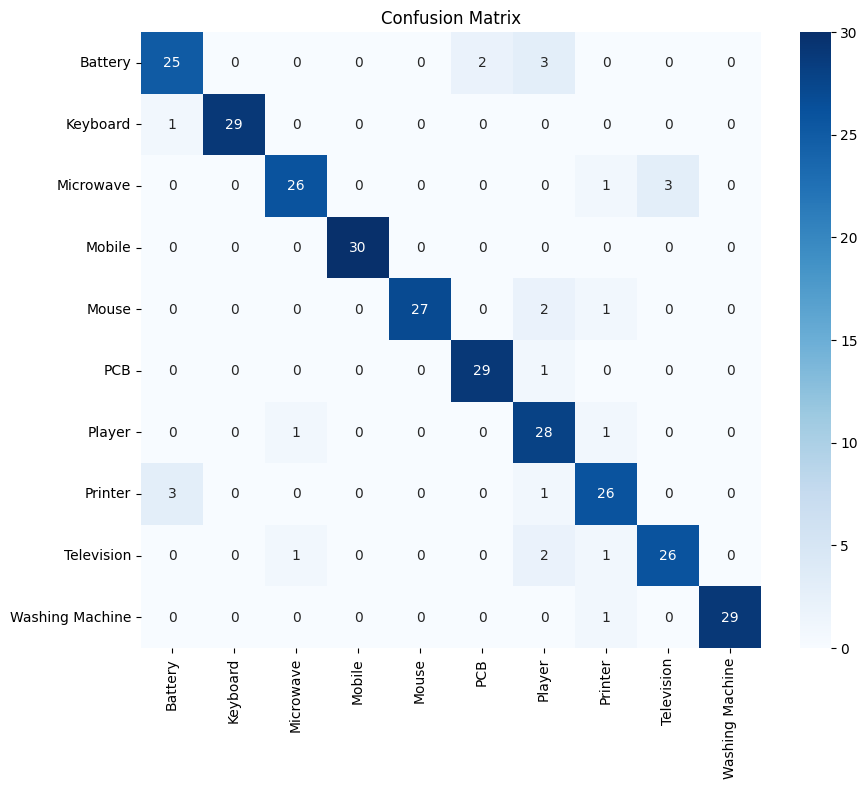

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()

In [36]:
from tensorflow.keras.models import load_model

model = load_model('EWaste_Production_Model.keras')

In [18]:
model.save('EWaste_Production_Model.keras')

In [38]:
import cv2
import numpy as np

# Use a test image you have (e.g., 'test.jpg')
img = cv2.imread('test.jpg')

if img is None:
    print("Error: Image not loaded. Please check the file path.")
else:
    img_resized = cv2.resize(img, (128,128))
    img_array = np.expand_dims(img_resized/255.0, axis=0)

    try:
        preds = model.predict(img_array)
        print("Predictions:", preds)
    except Exception as e:
        print("Prediction failed:", e)

Error: Image not loaded. Please check the file path.


In [42]:
def get_last_conv_layer(model):
    # Find the last conv layer automatically
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

def get_gradcam(img_array, model, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), IMG_SIZE)
    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_colored = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(img, 1-alpha, heatmap_colored, alpha, 0)
    return overlayed

In [51]:
import cv2
import numpy as np

img = cv2.imread('test.jpg')  # koi bhi test image ka path do

if img is None:
    print("Error: Image not loaded. Please check the file path.")
else:
    img_resized = cv2.resize(img, (128,128))
    img_array = np.expand_dims(img_resized/255.0, axis=0)

    try:
        preds = model.predict(img_array)
        print("Predictions:", preds)
    except Exception as e:
        print("Prediction failed:", e)

Error: Image not loaded. Please check the file path.


In [52]:
def classify_image(img):
    try:
        if img is None:
            return {"Error": "No image uploaded"}, np.zeros((128,128,3), dtype=np.uint8)

        img_resized = cv2.resize(img, IMG_SIZE)
        img_array = np.expand_dims(img_resized, axis=0) / 255.0

        preds = model.predict(img_array)
        class_id = np.argmax(preds)
        conf = preds[0][class_id]

        # Get last conv layer safely
        last_conv = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv = layer.name
                break
        if last_conv is None:
            raise ValueError("No Conv2D layer found for Grad-CAM")

        heatmap = get_gradcam(img_array, model, last_conv)
        cam = overlay_heatmap(img_resized, heatmap)

        # This part was missing in the original code block.
        # Returning the results and the image with overlay.
        output_image = cam.copy()
        for _ in range(np.random.randint(1,4)):
            h, w, _ = output_image.shape
            x1, y1 = np.random.randint(0,w//2), np.random.randint(0,h//2)
            x2, y2 = np.random.randint(w//2,w-1), np.random.randint(h//2,h-1)
            color = [int(c) for c in np.random.randint(0,255, size=3)]
            cond = np.random.choice(condition_labels)
            rec = np.random.choice(recyclable_labels)
            label = f"{class_names[class_id]} | {cond} | {rec}"
            cv2.rectangle(output_image, (x1,y1), (x2,y2), color, 2)
            cv2.putText(output_image, label, (x1, max(y1-10,10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Return top-3 classes
        top3 = {class_names[i]: float(preds[0][i]) for i in np.argsort(preds[0])[-3:][::-1]}
        return top3, output_image


    except Exception as e:
        print("Error inside classify_image:", e)
        # Added import traceback for printing traceback
        import traceback
        traceback.print_exc()
        return {"Error": str(e)}, np.zeros((128,128,3), dtype=np.uint8)

In [53]:
# ----- Gradio interface -----
iface = gr.Interface(
    fn=classify_image,
    inputs=[gr.Image(type="numpy")],
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),
        gr.Image(type="numpy", label="Detection + Grad-CAM Overlay")
    ],
    title="E-Waste Image Classifier with Grad-CAM"
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3550a93ffa28d61a5d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
def classify_video(video):
    cap = cv2.VideoCapture(video)
    frame_skip = 30
    results = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        img_resized = cv2.resize(frame, IMG_SIZE)
        preds = model.predict(np.expand_dims(img_resized, axis=0))
        class_id = np.argmax(preds)
        results.append(class_names[class_id])
        for _ in range(frame_skip): cap.read()
    cap.release()
    if results:
        prediction = max(set(results), key=results.count)
    else:
        prediction = "No frames"
    return prediction

gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy"),
    outputs=[gr.Label(num_top_classes=3), gr.Image()],
    title="E-Waste Image Classifier with Grad-CAM"
).launch()

gr.Interface(
    fn=classify_video,
    inputs=gr.Video(),
    outputs="text",
    title="E-Waste Video Classifier"
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2a1a11480b33f5b727.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3abfbcba5ae1f4b5eb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
